# Christmas Card Embeddings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
from tqdm import tqdm

torch.manual_seed(1)

## Load from songs.txt format
Read in lyrics from lyrics file. Lyrics are supplied in the format: Title\n\nArtist\n\nLyrics\n\n\nTitle2... Then save to tsv file

In [2]:
import pandas as pd

with open('lyrics.txt') as file:
    songs = file.read().split('\n\n\n')

songs_df = pd.DataFrame(dict(Title=[], Artist=[], Lyrics=[]))

for song in songs:
    title, artist, lyrics = song.split('\n\n')
    songs_df = songs_df.append(dict(Title=title, Artist=artist, Lyrics=lyrics), ignore_index=True)

songs_df.to_csv('songs.tsv', sep='\t')

#print(songs_df.describe())

## Load from songs.tsv format
Read in lyrics from lyrics file. Lyrics are in a tsv matching the structure of the dataframe

In [22]:
songs_df = pd.read_csv('songs.tsv', sep='\t')

#print(songs_df.describe())

Clean lyrics by removing puntuation and converting all characters into lower case

In [23]:
def pre_process(lyrics):
    # Remove newlines and split into words
    split_lyrics = lyrics.replace('\n', ' ').split()

    # Remove all punctuation and convert all words to lower case
    lyrics = [re.sub(r'[^\w\s]', '', word.lower()) for word in split_lyrics]
    lyrics = list(filter(lambda x: x != '', lyrics)) # Remove empty string from puctuation removal
    return ' '.join(lyrics)


songs_df.Lyrics = songs_df.Lyrics.apply(lambda x: pre_process(x))

vocabulary = set()
songs_df.Lyrics.apply(lambda x: vocabulary.update(x.split()))

total_size = sum(songs_df.Lyrics.apply(lambda x: len(x.split())))
vocab_size = len(vocabulary)

print(f'Total Words: {total_size}')
print(f'Unique Words: {vocab_size}')

Total Words: 22659
Unique Words: 2707


Create context target tuples to be used in the embedding training. Number of tuples generated should be the sum of the number of words $m$ in each song - the total number of songs $n$ * 2 * CONTEXT_SIZE. This number of terms is lost because a context window is required before and after the target middle term and as such, the 'boundary' tokens cannot be used as targets

In [15]:
CONTEXT_SIZE  = 2   # Number of terms to look back/ahead for each word
EMBEDDING_DIM = 256 # Size of each embedding vector

word_to_ix = {word: i for i, word in enumerate(vocabulary)}

context_targets = []

def get_context_targets(lyrics):
    split_lyrics = lyrics.split()

    for i in range(CONTEXT_SIZE, len(split_lyrics) - CONTEXT_SIZE):
        # Context is CONTEXT_SIZE words before and after word i, not including word i
        context = split_lyrics[i-CONTEXT_SIZE:i] + split_lyrics[i+1:i+CONTEXT_SIZE+1]
        context_targets.append((context, split_lyrics[i]))


songs_df.Lyrics.apply(lambda x: get_context_targets(x))

print(f'Expected: {total_size - len(songs_df) * 2 * CONTEXT_SIZE}')
print(f'Actual: {len(context_targets)}')


Expected: 22371
Actual: 22371


Define a function to retrieve the id values for a context

In [17]:
# Converts the words for a context into their ix form as a tensor
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [18]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, input):
        # reshape tensor to be 1D tensor instead of 2D, metrix like tensor
        embeds = self.embeddings(input).view((1, -1))
        out = self.linear1(embeds)
        out = F.relu(out)
        out = self.linear2(out)
        log_probs = F.softmax(out, dim=1)
        return log_probs

In [19]:
LEARNING_RATE = 0.001
EPOCHS = 5

criterion = nn.NLLLoss()
model = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
optimiser = optim.SGD(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for context, target in tqdm(context_targets):
        context_idx = make_context_vector(context, word_to_ix)

        model.zero_grad()

        log_probs = model(context_idx)

        loss = criterion(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        loss.backward()
        optimiser.step()

        total_loss += loss.item()

    losses.append(total_loss)

print(losses)

100%|██████████| 22371/22371 [00:19<00:00, 1129.38it/s]

[-8.168875810748432, -8.176999069895828, -8.18515699992713, -8.193350593617652, -8.201579383487115]


## Save the current version of the model

In [20]:
import json

with open('word_to_ix.txt', 'w') as file:
    json_string = json.dumps(word_to_ix)
    file.write(json_string)

torch.save(model, 'christmas_embeddings.pt')

## Load an existing version of the model

In [16]:
import json

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, input):
        # reshape tensor to be 1D tensor instead of 2D, metrix like tensor
        embeds = self.embeddings(input).view((1, -1))
        out = self.linear1(embeds)
        out = F.relu(out)
        out = self.linear2(out)
        log_probs = F.softmax(out, dim=1)
        return log_probs

# Load the model and the word_to_ix dictionary
model = torch.load('christmas_embeddings.pt')
with open('word_to_ix.txt', 'r') as json_file:
    word_to_ix = json.load(json_file)

## Create the graph
Set the two words to draw the vectors to. Ensure the words are lower case and match any pre-processing applied. Also set the number of points other than the to specified points to render. 400 looks good but can be changed if a denser or sparser snowstorm is desired

In [25]:
WORD_1 = 'te'
WORD_2 = 'amo'

NUM_POINTS = 400

Import the snowflake SVG and create a custome matplotlib marker with it. Then reduce the dimensionality of the embeddings down to 3 dimensions to be represented in 3D scatter plot. 

ValueError: too many values to unpack (expected 3)

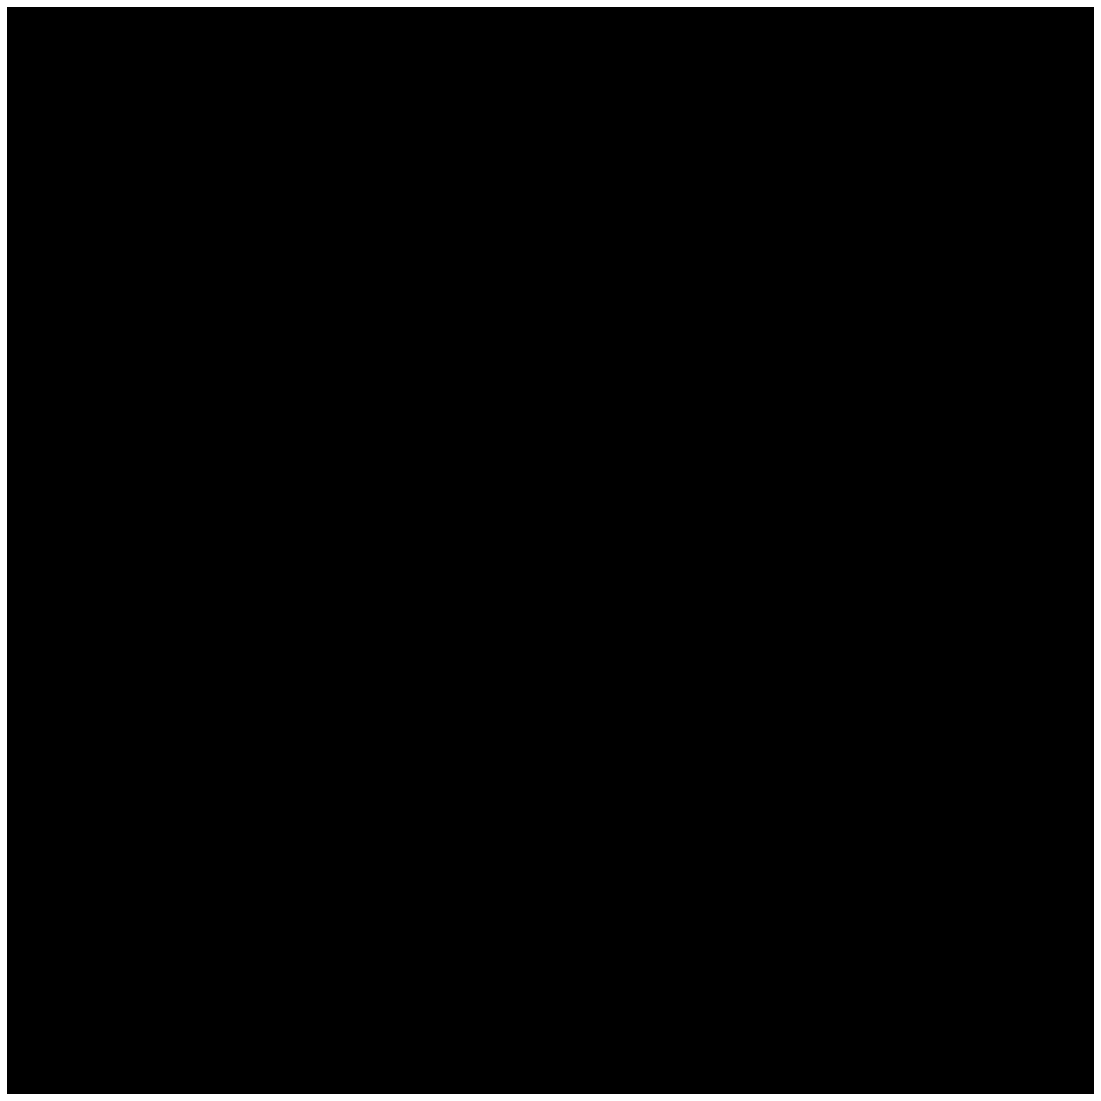

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

snowflake_path, attributes = svg2paths('snowflake.svg')
snowflake_marker = parse_path(attributes[0]['d'])
snowflake_marker.vertices -= snowflake_marker.vertices.mean(axis=0)
snowflake_marker = snowflake_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
snowflake_marker = snowflake_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))

pca = PCA(n_components=3)
pca_results = pca.fit_transform(model.embeddings.weight.detach())

fig = plt.figure( figsize=(20, 20))
ax = plt.axes(projection='3d')
ax.axis('off')
ax.set_facecolor('black')

word1_idx = word_to_ix[WORD_1]
word2_idx = word_to_ix[WORD_2]

num = len(word_to_ix)
np.random.seed(0)
random_idxs = np.random.randint(low=0, high=num, size=NUM_POINTS)

all_idxs = np.append(random_idxs, [word1_idx, word2_idx])
x_data = pca_results[all_idxs, 0]
y_data = pca_results[all_idxs, 1]
z_data = pca_results[all_idxs, 2]

ax.set_title('Christmas Embeddings', fontsize=20)
ax.invert_zaxis() # Z-Axis inverted in this example to make the words appear in the right order
ax.scatter3D(x_data, y_data, z_data, s=70, c='white', marker=snowflake_marker)

x_1 = [0, pca_results[word1_idx, 0]]
y_1 = [0, pca_results[word1_idx, 1]]
z_1 = [0, pca_results[word1_idx, 2]]

x_2 = [0, pca_results[word2_idx, 0]]
y_2 = [0, pca_results[word2_idx, 1]]
z_2 = [0, pca_results[word2_idx, 2]]

ax.plot(x_1, y_1, z_1, color='#bb2528')
ax.plot(x_2, y_2, z_2, color='#146b3a')

t_1 = ax.text(pca_results[word1_idx, 0], pca_results[word1_idx, 1], pca_results[word1_idx, 2], WORD_1, fontsize=30, c='#bb2528')
t_1.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='black'))

t_2 = ax.text(pca_results[word2_idx, 0], pca_results[word2_idx, 1], pca_results[word2_idx, 2], WORD_2, fontsize=30, c='#146b3a')
t_2.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='black'))